# Детекция фрода карточных транзакций
**Информация:**

* transaction_time: дата и время совершения транзакции

* merch: название или идентификатор продавца или торговой точки, где была совершена транзакция

* cat_id: идентификатор категории товара или услуги, к которой относится транзакция

* amount: сумма транзакции

* name_1, name_2: имена, связанные с транзакцией

* gender: пол клиента

* street: название улицы

* one_city: город

* us_state: штат США

* post_code: почтовый индекс

* lat, lon: широта и долгота

* population_city: численность населения города проживания клиента

* jobs: уровень занятости

* merchant_lat, merchant_lon: широта и долгота местоположения продавца или точки продажи

* target: целевая переменная

**Размеры:**
train (786431, 18), test (262144, 17)

Соревнование на Kaggle: https://www.kaggle.com/competitions/teta-ml-1-2025

In [1]:
pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.5 MB/s eta 0:00:00


In [26]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shap


from lightgbm import LGBMClassifier
from math import atan2, cos, radians, sin, sqrt
from scipy.stats import zscore
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import auc, f1_score, make_scorer, precision_recall_curve

In [3]:
!gdown -- 1mQzq52RTnPGUBZBidTJdE9B7vFNk3dXg
test = pd.read_csv('test.csv')

Downloading...
From: https://drive.google.com/uc?id=1mQzq52RTnPGUBZBidTJdE9B7vFNk3dXg
To: /content/test.csv
100% 47.7M/47.7M [00:00<00:00, 52.1MB/s]


In [4]:
!gdown -- 1neEIri_2BZWN94wyfeoQ0pwQ2qtWQQIO
train = pd.read_csv('train.csv')
train.head(2)

Downloading...
From (original): https://drive.google.com/uc?id=1neEIri_2BZWN94wyfeoQ0pwQ2qtWQQIO
From (redirected): https://drive.google.com/uc?id=1neEIri_2BZWN94wyfeoQ0pwQ2qtWQQIO&confirm=t&uuid=e6008731-68c6-499f-87f5-804239650fa0
To: /content/train.csv
100% 145M/145M [00:01<00:00, 80.3MB/s]


,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon,target
0,2019-12-27 15:21,fraud_Cormier LLC,health_fitness,148.04,Daniel,Martinez,M,8510 Acevedo Burgs,Kent,OR,97033,45.0838,-120.6649,60,Museum education officer,45.042827,-120.709327,0
1,2019-04-17 23:09,"fraud_Brown, Homenick and Lesch",health_fitness,39.40,Grace,Williams,F,28812 Charles Mill Apt. 628,Plantersville,AL,36758,32.6176,-86.9475,1412,Drilling engineer,31.872266,-87.828247,0


## Обработка данных

#### Feature engineering

In [5]:
# выделим час из времени транзакции
train['transaction_hour'] = pd.to_datetime(train['transaction_time']).dt.hour
test['transaction_hour'] = pd.to_datetime(test['transaction_time']).dt.hour

# добавим циклические признаки для часа
train['hour_sin'] = np.sin(2 * np.pi * train['transaction_hour'] / 24)
train['hour_cos'] = np.cos(2 * np.pi * train['transaction_hour'] / 24)
test['hour_sin'] = np.sin(2 * np.pi * test['transaction_hour'] / 24)
test['hour_cos'] = np.cos(2 * np.pi * test['transaction_hour'] / 24)

In [9]:
# обработка географических параметров
def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float, n_digits: int = 0) -> float:
    """
        Функция для расчёта расстояния от точки А до Б по прямой

        :param lat1: Широта точки А
        :param lon1: Долгота точки А
        :param lat2: Широта точки Б
        :param lon2: Долгота точки Б
        :param n_digits: Округляем полученный ответ до n знака после запятой
        :return: Дистанция по прямой с точностью до n_digits
    """

    lat1, lon1, lat2, lon2 = round(lat1, 6), round(lon1, 6), round(lat2, 6), round(lon2, 6)
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)

    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2

    return round(2 * 6372800 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)), n_digits)  # метры.сантиметры


def bearing_degree(lat1: float, lon1: float, lat2: float, lon2: float, n_digits: int = 0) -> float:
    """
        Функция для расчёта угла между прямой [((lat1, lon1), (lat2, lon2)), (нулевой мередиан)]

        :param lat1: Широта точки А
        :param lon1: Долгота точки А
        :param lat2: Широта точки Б
        :param lon2: Долгота точки Б
        :param n_digits: Округляем полученный ответ до n знака после запятой
        :return: Значение угла с точностью до n_digits
    """

    lat1, lon1 = np.radians(round(lat1, 6)), np.radians(round(lon1, 6))
    lat2, lon2 = np.radians(round(lat2, 6)), np.radians(round(lon2, 6))

    dlon = (lon2 - lon1)
    numerator = np.sin(dlon) * np.cos(lat2)
    denominator = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))

    theta = np.arctan2(numerator, denominator)
    theta_deg = (np.degrees(theta) + 360) % 360

    return round(theta_deg, n_digits)


# добавление географических расстояний и углов между разными точками
train['bearing_degree_1'] = bearing_degree(train['lat'], train['lon'], train['merchant_lat'], train['merchant_lon'], ).values
test['bearing_degree_1'] = bearing_degree(test['lat'], test['lon'], test['merchant_lat'], test['merchant_lon'], ).values
train['hav_dist_1'] = haversine_distance(train['lat'], train['lon'], train['merchant_lat'], train['merchant_lon'], ).values
test['hav_dist_1'] = haversine_distance(test['lat'], test['lon'], test['merchant_lat'], test['merchant_lon'], ).values

train['bearing_degree_2'] = bearing_degree(train['lat'], train['lon'], 0, 0, ).values
test['bearing_degree_2'] = bearing_degree(test['lat'], test['lon'], 0, 0, ).values
train['hav_dist_2'] = haversine_distance(train['lat'], train['lon'], 0, 0, ).values
test['hav_dist_2'] = haversine_distance(test['lat'], test['lon'], 0, 0, ).values

train['bearing_degree_3'] = bearing_degree(0, 0, train['merchant_lat'], train['merchant_lon'], ).values
test['bearing_degree_3'] = bearing_degree(0, 0, test['merchant_lat'], test['merchant_lon'], ).values
train['hav_dist_3'] = haversine_distance(0, 0, train['merchant_lat'], train['merchant_lon'], ).values
test['hav_dist_3'] = haversine_distance(0, 0, test['merchant_lat'], test['merchant_lon'], ).values

#### Emissions and coding

In [6]:
# разделим признаки на числовые и категориальные
numeric_features = ['amount', 'lat', 'lon', 'population_city', 'merchant_lat', 'merchant_lon']

cat_columns = ['merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'post_code', 'jobs']


Количество аномальных значений для числового признака: amount
train 7614 test 2694


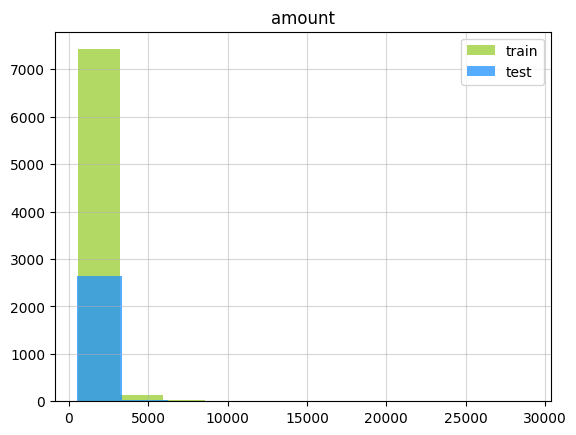


Количество аномальных значений для числового признака: lat
train 2804 test 940


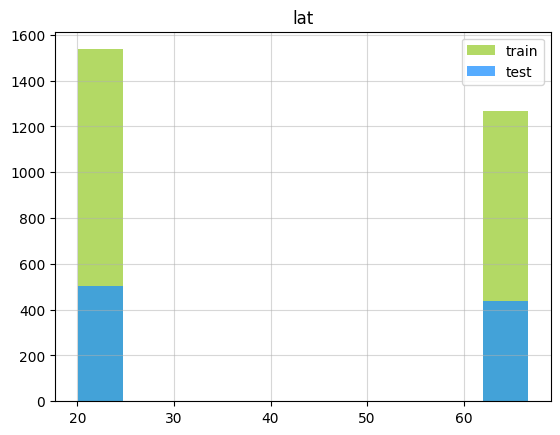


Количество аномальных значений для числового признака: lon
train 2804 test 940


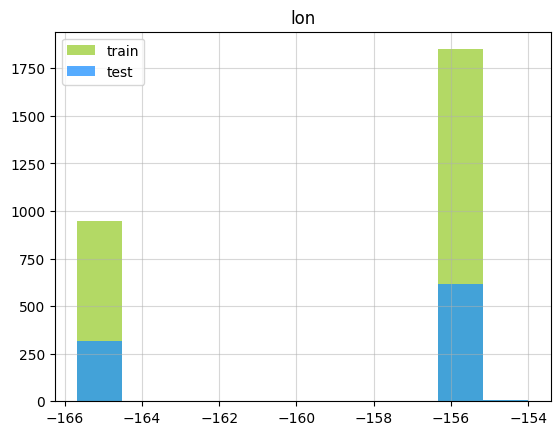


Количество аномальных значений для числового признака: population_city
train 20039 test 6572


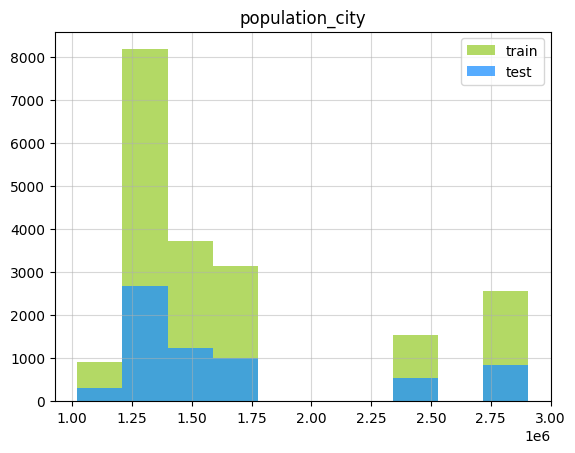


Количество аномальных значений для числового признака: merchant_lat
train 2804 test 940


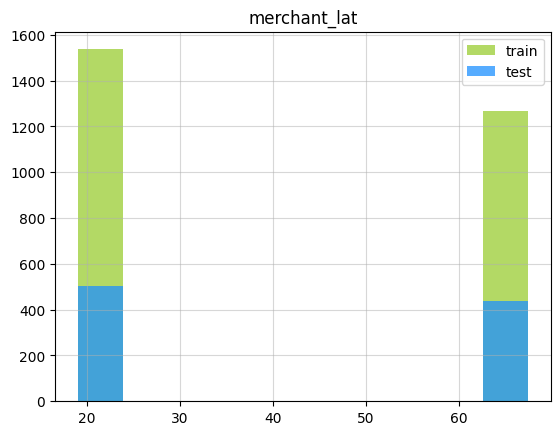


Количество аномальных значений для числового признака: merchant_lon
train 2804 test 940


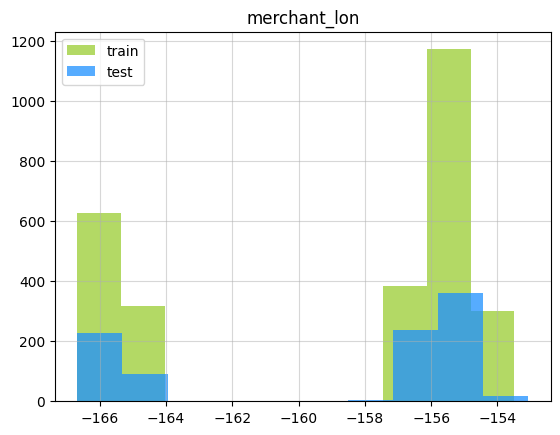


Количество уникальных значений для категориальных признаков:
merch 693
cat_id 14
name_1 348
name_2 479
gender 2
street 965
one_city 879
us_state 51
post_code 952
jobs 493
Общее колличество уникальных значений: 4876


In [7]:
# анализ выбросов для числовых признаков
for one_feature in numeric_features:

  mask_outliesr_train = np.abs(zscore(train[one_feature].values)) >= 3
  mask_outliesr_test = np.abs(zscore(test[one_feature].values)) >= 3

  print(f"\nКоличество аномальных значений для числового признака: {one_feature}")
  print('train', sum(mask_outliesr_train), 'test', sum(mask_outliesr_test))

  plt.hist(train[mask_outliesr_train][one_feature], alpha = 0.75, label='train', color = 'yellowgreen')
  plt.hist(test[mask_outliesr_test][one_feature], alpha = 0.75, label='test', color = 'dodgerblue')
  plt.legend()
  plt.title(one_feature)
  plt.grid(alpha=0.5)
  plt.show()

# анализ выбросов для категориальных признаков
c = 0
print(f"\nКоличество уникальных значений для категориальных признаков:")
for one_feature in cat_columns:
  print(one_feature, train[one_feature].nunique())
  c += train[one_feature].nunique()
print(f"Общее колличество уникальных значений: {c}")

**Анализ рузультатов:**
1. **Числовые признаки:** Гистограммы распределения выбросов в train и test показывают, что выбросы имеют схожую природу в обеих выборках. Заметна асимметрия в распределении выбросов (в train их значительно больше).

2. **Категориальные признаки:** Есть признаки с большим числом уникальных значений (street 965, post_code 952 и one_city 879), что указывает на высокую кардинальность и может усложнить кодирование, так как увеличит размерность данных. Также суммарно 4876 уникальных значений — это много, поэтому воспользуемся методом target encoding для кодирования категориальных переменных, который заменит категории средним значением целевой переменной.

In [8]:
# CatBoostEncoder для категориальных переменных
target_enc = ce.CatBoostEncoder(cols=cat_columns)
target_enc = target_enc.fit(train[cat_columns], train['target'])

train = train.join(target_enc.transform(train[cat_columns]).add_suffix('_cb'))
test = test.join(target_enc.transform(test[cat_columns]).add_suffix('_cb'))

In [10]:
# выберем все обработанные переменные для использования в модели
model_features = ['amount', 'lat', 'lon', 'hour_sin', 'hour_cos', 'population_city', 'merchant_lat', 'merchant_lon',
    'bearing_degree_1', 'bearing_degree_2', 'bearing_degree_3', 'hav_dist_1', 'hav_dist_2', 'hav_dist_3',
    'merch_cb', 'cat_id_cb', 'name_1_cb', 'name_2_cb', 'gender_cb', 'street_cb', 'one_city_cb', 'us_state_cb', 'post_code_cb', 'jobs_cb']

## LGBMClassifier

#### Подбор гиперпараметров

In [18]:
# настройка гиперпараметров
param_grid = {
    'n_estimators': np.arange(100, 250, 500),
    'max_depth': [5, 7, 9],
    'num_leaves': [15, 31, 63],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

# модель с базовыми параметрами
model = LGBMClassifier(class_weight='balanced', random_state=14)


X_train, X_test, y_train, y_test = train_test_split(
    train[model_features], train['target'], test_size=0.25, random_state=42,
    stratify=train['target']
)

# настройка рандомизированного поиска
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=14
)

# Запуск поиска
random_search.fit(X_train[model_features], y_train)

# Лучшие параметры
print("Best parameters:", random_search.best_params_)
print("Best F1-score:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 3378, number of negative: 586445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4499
[LightGBM] [Info] Number of data points in the train set: 589823, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters: {'reg_lambda': 0, 'reg_alpha': 0.1, 'num_leaves': 63,

Интересный результат, но используем его только чатсично, так как это рандомный перебор параметров и есть спорные моменты:

1. reg_lambda: 0 и reg_alpha: 0.1 - странный выбор, так как в основном для параметров регуляризации выбирают одиноковое значение.

2. n_estimators: 100 - возможно слишком маленькое значение?

P.S. Заглянем в будущее и посмотрим результаты модели для:
* n_estimators=100: F1-score: 0.8149819494584838
* n_estimators=250: F1-score: 0.822808671065033
* n_estimators=500: F1-score: 0.8249422632794458

#### Обучение модели и подбор порога

In [28]:
# обучаем модель на 75% данных
model = LGBMClassifier(
    n_estimators=250,        # количество деревьев, большое значение - риск переобучения
    max_depth=9,             # глубина деревьев, большое значение - риск переобучени
    num_leaves=63,           # листья дерева, ≤ 2^max_depth
    reg_alpha=0.1,           # L1-регуляризация, для борьбы с переобучением
    reg_lambda=0.1,          # L2-регуляризация, смысл тотже, часто значение = reg_alpha
    class_weight='balanced', # автоматическая балансировка веса классов
    random_state=14          # фиксирует случайность для воспроизводимости результатов
)

X_train, X_test, y_train, y_test = train_test_split(
    train[model_features], train['target'], test_size=0.25, random_state=42,
    stratify=train['target']
)
model.fit(X_train, y_train)

# подбор порога
predictions = model.predict_proba(X_test[model_features])[:, 1]                                     # вероятности того, что каждый образец в X_test принадлежит к классу 1
precisions, recalls, thresholds = precision_recall_curve(y_test, predictions)                       # точность и полнота для разных порогов, thresholds — пороги, при которых достигаются эти значения
best_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls + 1e-9))]  # порог, который максимизирует F1-меру
predictions_binary = predictions >= best_threshold                                                  # преобразование вероятностей в бинарные предсказания, используя оптимальный порог

print(f"F1-score: {f1_score(y_test, predictions_binary)}")

[LightGBM] [Info] Number of positive: 3378, number of negative: 586445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4499
[LightGBM] [Info] Number of data points in the train set: 589823, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

#### Кросс-валидация модели

In [38]:
# делим на обучающий и тестовый наборы
X = train[model_features]
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25,
    random_state=42, stratify=y
)

# кросс-валидация
n_splits = 3
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=14)
f1_scores = []
best_thresholds = []

for train_idx, val_idx in skf.split(X_train, y_train):
    # делим на тренировочную и валидационную части фолда
    X_fold_train, y_fold_train = X.iloc[train_idx], y.iloc[train_idx]
    X_fold_val, y_fold_val = X.iloc[val_idx], y.iloc[val_idx]

    model.fit(X_fold_train, y_fold_train)

    # предсказания на валидации
    val_probs = model.predict_proba(X_fold_val)[:, 1]

    # подбор порога для максимизации F1
    precisions, recalls, thresholds = precision_recall_curve(y_fold_val, val_probs)
    f1_scores_fold = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    best_threshold = thresholds[np.argmax(f1_scores_fold)]

    best_thresholds.append(best_threshold)
    predictions_binary = val_probs >= best_threshold
    f1_scores.append(f1_score(y_fold_val, predictions_binary))

# вывод по кросс-валидации
print(f"CV F1-score: {np.mean(f1_scores):.4f} (±{np.std(f1_scores):.4f})")
print(f"Best thresholds: {best_thresholds}")

# средний порог по фолдам
mean_best_threshold = np.mean(best_thresholds)

# обучение на всех тренировочных данных
model.fit(X_train, y_train)

# средний порог из кросс-валидации
test_probs = model.predict_proba(X_test)[:, 1]
test_predictions = test_probs >= mean_best_threshold
print(f"\nTest F1-score (CV threshold): {f1_score(y_test, test_predictions):.4f}")

[LightGBM] [Info] Number of positive: 2293, number of negative: 390922
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.342440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4501
[LightGBM] [Info] Number of data points in the train set: 393215, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

**Результаты кросс-валидации:**

1. Низкое стандартное отклонение (±0.0008) указывает, что модель не переобучается и дает схожие результаты на разных подвыборках данных, разброс между фолдами минимален.

2. Тестовый F1-score на 0.8% ниже, чем средний по CV, возможно тестовые данные содержат более сложные примеры.

3. Пороги варьируются от 0.89 до 0.94, так как оптимальный порог зависит от разбиения данных. Высокий порог (близкий к 1) означает, что модель предсказывает положительный класс только при очень высокой уверенности.

4. Изначальный F1 (0.8228) близок к тестовому с порогом из CV (0.8146). Это подтверждает корректность обоих подходов: в исходном подходе порог подбирался на тестовом наборе (риск overfitting), а в кросс-валидации — на валидационных фолдах (более честная оценка).

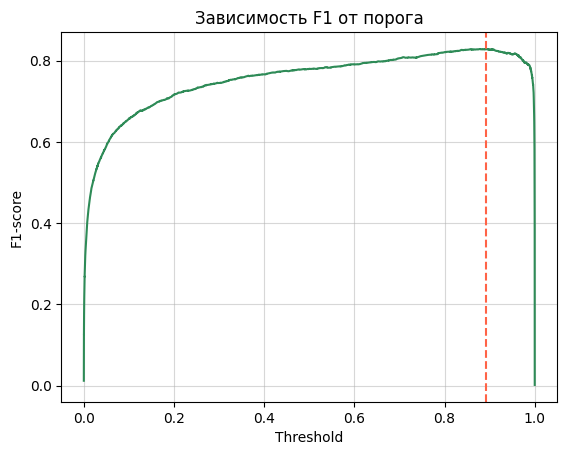

In [36]:
# зависимость F1-меры от порога классификации
plt.plot(thresholds, 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-9), color='seagreen')
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("Зависимость F1 от порога")
plt.axvline(best_threshold, color='tomato', linestyle='--')
plt.grid(alpha=0.5)
plt.show()

**Описание графика:**

Широкий пик на графике говорит о устойчивости модели к выбору порога — небольшое изменение порога не сильно влияет на F1.

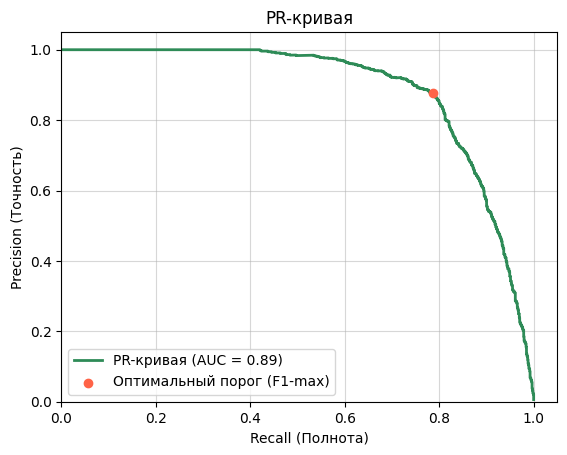

In [37]:
# площадь под кривой (AUC-PR)
pr_auc = auc(recalls, precisions)

plt.plot(recalls, precisions, lw=2, color='seagreen', label=f'PR-кривая (AUC = {pr_auc:.2f})')

plt.scatter(recalls[np.argmax(2 * (precisions * recalls) / (precisions + recalls + 1e-9))],
            precisions[np.argmax(2 * (precisions * recalls) / (precisions + recalls + 1e-9))],
            color='tomato', zorder=10, label='Оптимальный порог (F1-max)')

plt.xlabel('Recall (Полнота)')
plt.ylabel('Precision (Точность)')
plt.title('PR-кривая')
plt.legend(loc='lower left')
plt.grid(alpha=0.5)
plt.ylim(0, 1.05)
plt.xlim(0, 1.05)
plt.show()

**Описание графика:**

Для дисбалансированных данных AUC-PR информативнее, чем ROC-AUC, pr_auc показывает площадь под кривой. Значение AUC = 0.89 (близко к 1) можно считать хорошим результатом работы модели. Кривая расположена близко к правому верхнему углу, соответсвенно у нас высокий precision и recall, что также говорит о хорошей работе модели. Оптимальная точка — баланс precision/recall для максимизации F1-меры.




/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


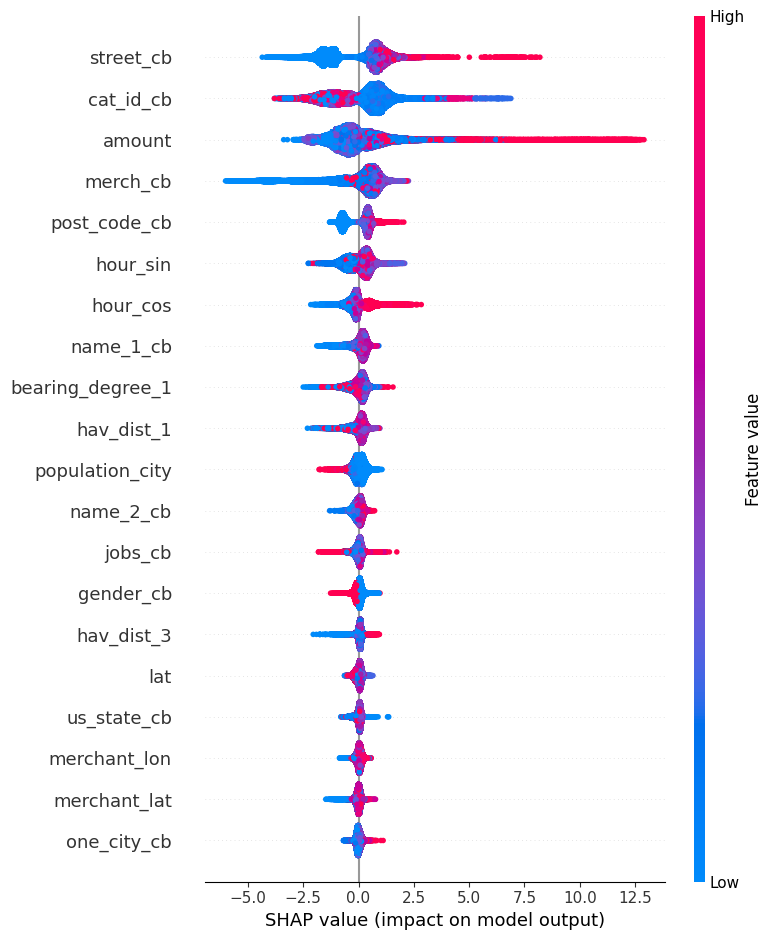

CPU times: user 25min 58s, sys: 2.21 s, total: 26min
Wall time: 18min 5s


In [40]:
# анализ важности признаков на основе SHAP
%%time
shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

**Описание графика:**

1. Признак 'street_cb': Улицы, которые в тренировочных данных ассоциировались с высокими значениями целевой переменной (возможно, дорогие районы), увеличивают предсказание модели. Напротив, улицы с исторически низкими значениями целевой переменной (возможно, неблагополучные районы) снижают предсказание.

2. Признак 'amount' имеет много красных точек справа и синих слева → чем больше сумма транзакции, тем выше предсказание модели.

3. Признак 'cat_id_cb': модель интерпретирует низкие cat_id как положительный фактор. Целевая переменная — детекция фрода, соответственно высокий риск у категории (cat_id) снижает предсказание модели для "хороших" транзакций.

4. Признак 'merch_cb': продавцы/точки, связанные с высокими значениями целевой переменной (красные точки справа), положительно влияют на предсказание модели, соответсвенно модель флагует транзакции из точек, где ранее часто происходили мошеннические операции.

5. Признаки 'hour_sin', 'hour_cos': циклическая зависимость предсказаний от времени суток, модель оценивает полночь (00:00) и полдень (12:00) как периоды с максимальным влиянием на целевую переменную (красные точки справа для hour_cos), дневные часы (9:00–15:00) могут неоднозначно влиять на предсказания из-за разнородной активности пользователей.


In [39]:
# финальное обучение на всех данных
model_final = LGBMClassifier(
    n_estimators=250,
    max_depth=9,
    num_leaves=63,
    reg_alpha=0.1,
    reg_lambda=0.1,
    class_weight='balanced',
    random_state=14
)
model.fit(train[model_features], train['target'])

test_predictions = model.predict_proba(test[model_features])[:, 1]
test_binary = test_predictions >= mean_best_threshold

# Создаем файл сабмита
sample_submission = pd.DataFrame({
    'index': test.index,
    'prediction': test_binary.astype(int)
})
sample_submission.to_csv('sample_submission.csv', index=False)

[LightGBM] [Info] Number of positive: 4504, number of negative: 781927
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4498
[LightGBM] [Info] Number of data points in the train set: 786431, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




---


**intro — описание финального решения:**
1.  **Обработка данных.** Для признака transaction_time добавили циклические признаки для часа. Для географических признаков lat, lon,merchant_lat и merchant_lon расчитаны расстояния и углы между точками. Категориальные признаки закодированы с помощью CatBoostEncoder, так как в данных много уникальных значений.

2. **Алгоритм.** LGBMClassifier основан на градиентном бустинге, который специализируется на задачах классификации. Подходит для поставленной задачи бинарной классификации с дисбалансом данных. Также быстрее работает на больших данных, но может быть чувствителен к переобучению

3. **Особенности при обучении.** Настройка гиперпараметров: подбор оптимальных глубины деревьев и количества листьев, параметры регуляризации для борьбы с переобучением, автоматическая балансировка веса классов. Сделан рандомный перебор сетки параметров для 50 итераций.

4. **Валидация алгоритма.** Результаты кросс-валидации показали работоспособность модели, результаты стабильны, а расхождение между кросс-валидацией и тестом незначительно. Графики завиисмости F1 от порога и PR-кривой подтверждают эти результаты.


---



**outro — описание вариантов по дальнейшему улучшению итогового подхода:**

1. Улучшить feature engineering. Например добавить статистику по пользователям для name_1, name_2: история транзакций пользователя, средний amount пользователя, максимальный amount за последние 30 дней, стандартное отклонение сумм (std_amount_user). Для amount можно применить логарифмирование: `train['amount_log'] = np.log1p(train['amount'])`

2. Ансамблирование. Например, объединить LightGBM с CatBoost: `estimators = [  ('lgbm', LGBMClassifier(...)), ('catboost', CatBoostClassifier(verbose=0))]`.

3. Проанализировать результаты SHAP и удалить признаки с нулевой важностью.

*P.S. Это мой первый опыт в ML, поэтому использовала код с занятия и просто немного его улучшила.*
